In [2]:
### Preprocessing ###
# Data Loading
import pandas as pd
df = pd.read_csv('wdbc.csv', header=None)
df.shape

(569, 32)

In [4]:
# X, y 변수 스케일링
from sklearn.preprocessing import LabelEncoder
X = df.loc[:, 2:].values # 30개의 feature를 할당
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y) #class[B, M]을 class [0, 1]로 전환
le.classes_
le.transform(['M', 'B']) # 확인

array([1, 0])

In [5]:
print(1-y.mean())

0.6274165202108963


In [6]:
# 전체 data를 training data와 test data로 split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.20,
        stratify=y, random_state=1)

In [7]:
### Pipeline Streaming: 표준화 -> PCA -> Logistic Regression ###
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
# 적용 순서대로 나열
pipe_lr = make_pipeline(StandardScaler(),
    PCA(n_components=4),
    LogisticRegression(random_state=1, solver='lbfgs'))
# 표준화(fit -> transform) -> PCA(fit -> transform) -> Logistic Reg fit 순서로 처리
pipe_lr.fit(X_train, y_train)
# 표준화 transform -> PCA transform -> Logistic Reg prediction 순서로 처리
y_train_pred = pipe_lr.predict(X_train)
y_test_pred = pipe_lr.predict(X_test)

In [8]:
# Accuracy score
print(pipe_lr.score(X_train, y_train)) # Train accuracy
print(pipe_lr.score(X_test, y_test)) # Test accuracy

0.967032967032967
0.956140350877193


In [9]:
### K-fold cross-validation using pipeline ###
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=pipe_lr, X=X_train, y=y_train, cv=10)
print('CV accuracy score: %s' % scores)

import numpy as np
print('CV accuracy: %.sf +/- %.3f' %(np.mean(scores), np.std(scores)))

CV accuracy score: [0.97826087 0.95652174 0.95652174 0.95652174 0.91304348 0.95555556
 0.97777778 0.97777778 1.         0.97777778]
CV accuracy: f +/- 0.022


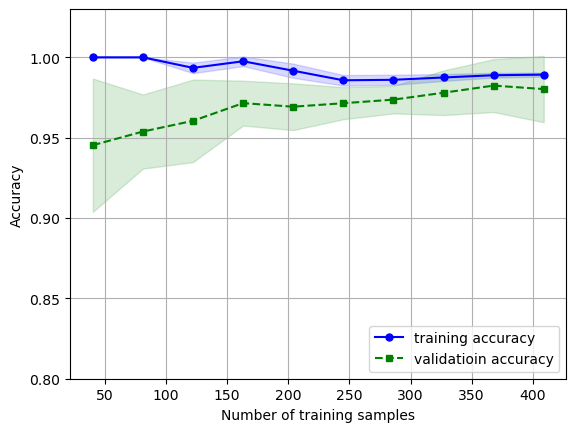

In [21]:
### Bias-variance trade-off 그래프로 확인하기 ###
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
pipe_lr = make_pipeline(StandardScaler(),
    LogisticRegression(penalty='l2', random_state=1, solver='lbfgs'))
train_sizes, train_scores, test_scores = \
    learning_curve(estimator=pipe_lr, X=X_train, y=y_train,
        train_sizes=np.linspace(0.1, 1.0, 10), cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue',
    marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std,
    train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green',
    linestyle='--', marker='s', markersize=5,
    label='validatioin accuracy')
plt.fill_between(train_sizes, test_mean + test_std,
    test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.show()

In [22]:
### Grid search에 의한 초모수 결정 (SVM) ###
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C' : param_range, 'svc__kernel' : ['linear']},
              {'svc__C' : param_range, 'svc__gamma' : param_range,
               'svc__kernel' : ['rbf']}]
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid,
                  scoring='accuracy', cv=10)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

clf = gs.best_estimator_
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
clf.score(X_test, y_test)

0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
0.989010989010989


0.9736842105263158

In [23]:
### Nested scross-validation을 이용한 초모수 결정 ###
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid,
                  scoring='accuracy', cv=3)
scores = cross_val_score(gs, X, y, scoring='accuracy', cv=5)

print('CV accuuacy: %.8f +/- %.3f' %(np.mean(scores), np.std(scores)))

CV accuuacy: 0.97893184 +/- 0.007


In [24]:
# Decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
inner_cv=KFold(n_splits=3, shuffle=True, random_state=0)
outer_cv=KFold(n_splits=5, shuffle=True, random_state=0)
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy', cv=inner_cv)
scores = cross_val_score(gs, X, y, scoring='accuracy', cv=outer_cv)
print('CV accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

CV accuracy: 0.944 +/- 0.012


In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
inner_cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
outer_cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_dapth':[1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy', cv=inner_cv)
scores = cross_val_score(gs, X, y, scoring='accuracy', cv=outer_cv)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: nan +/- nan


c:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 891, in fit
    self._run_search(evaluate_candidates)
  File "c:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 1392, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
